## Final Comparision

ARIMA: 378 overlapping dates
SARIMA: 58 overlapping dates
Prophet: 2515 overlapping dates

Model Comparison:

               MAE         MSE       RMSE
ARIMA    20.019256  689.601386  26.260262
SARIMA    2.017461    6.258892   2.501778
Prophet   5.563332   58.477335   7.647047


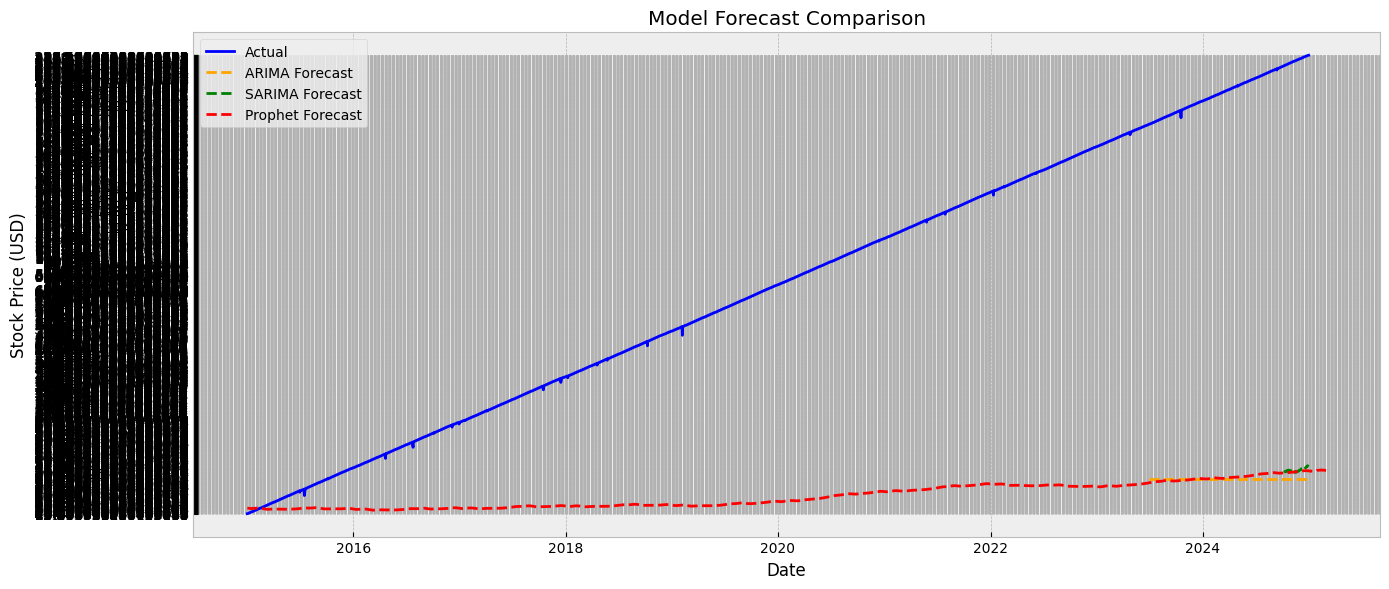

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and prepare original data
df = pd.read_csv('AAPL_clean.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Load predictions
arima_pred = pd.read_csv('Models/arima_predictions.csv', parse_dates=['Date'], index_col='Date')
sarima_pred = pd.read_csv('Models/sarima_predictions.csv', parse_dates=['Date'], index_col='Date')
prophet_pred = pd.read_csv('Models/prophet_predictions.csv', parse_dates=['Date'], index_col='Date')

# Ensure index is datetime
for pred in [arima_pred, sarima_pred, prophet_pred]:
    pred.index = pd.to_datetime(pred.index)

# ✅ Build a unified set of forecast dates for fair comparison
all_forecast_dates = arima_pred.index.union(sarima_pred.index).union(prophet_pred.index)

# ✅ Limit actuals only to dates that appear in at least one forecast
y_true_all = df['Close'].reindex(all_forecast_dates).dropna()

# Metric function
def calculate_metrics(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

# Align function
def align(true_series, forecast_df):
    forecast = forecast_df['Forecast']
    actual = true_series.reindex(forecast.index).dropna()
    forecast = forecast.reindex(actual.index)
    return actual, forecast

# Evaluate models
results = {}
for name, pred_df in zip(['ARIMA', 'SARIMA', 'Prophet'], [arima_pred, sarima_pred, prophet_pred]):
    y_true_aligned, y_pred_aligned = align(y_true_all, pred_df)
    print(f"{name}: {len(y_true_aligned)} overlapping dates")
    if len(y_true_aligned) > 0:
        mae, mse, rmse = calculate_metrics(y_true_aligned, y_pred_aligned)
        results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    else:
        results[name] = {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan}

# Results table
comparison_df = pd.DataFrame(results).T
print("\nModel Comparison:\n")
print(comparison_df)

# Plot forecasts vs actuals
plt.figure(figsize=(14, 6))
plt.style.use('bmh')  # Optional style
plt.plot(df['Close'], label='Actual', color='blue', linewidth=2)
plt.plot(arima_pred['Forecast'], label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(sarima_pred['Forecast'], label='SARIMA Forecast', linestyle='--', color='green')
plt.plot(prophet_pred['Forecast'], label='Prophet Forecast', linestyle='--', color='red')
plt.legend()
plt.title("Model Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.tight_layout()
plt.grid(True)
plt.show()
